### Imports

In [1]:
import base64
import os
from copy import deepcopy
from io import BytesIO
from typing import List

from PIL import Image
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from langchain_core.runnables import RunnableLambda
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field

from client import DetectionClient, SegmentationClient
from client.utils import draw_detections

BASE_URL="https://13vmwvgv1f8z6k-8008.proxy.runpod.net/"
VLLM_BASE_URL=os.path.join(BASE_URL, "vllm/v1")
IMAGE_BASE_URL=os.path.join(BASE_URL, "image")

TEST_IMAGE=Image.open("./test.jpg")

### Multimodal VLLM Inference

#### Normal Usage

In [2]:
buffered = BytesIO()
TEST_IMAGE.save(buffered, format="JPEG")
img_base64 = base64.b64encode(buffered.getvalue()).decode()

chat = ChatOpenAI(
    model="model",
    api_key="EMPTY",
    base_url=VLLM_BASE_URL,
    max_tokens=8192,
    extra_body={
        "chat_template_kwargs": {"enable_thinking": False}
    },
)

chat_thinking = ChatOpenAI(
    model="model",
    api_key="EMPTY",
    base_url=VLLM_BASE_URL,
    max_tokens=8192,
    extra_body={
        "chat_template_kwargs": {"enable_thinking": True}
    },
)

messages = [
    SystemMessage(content="You are a helpful assistant that can see and understand images."),
    HumanMessage(content=[
        {"type": "text", "text": "What is in this image? Explain in great detail."},
        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"}}
    ]),
]

In [3]:
chunks_thinking = []
for chunk in chat_thinking.stream(messages):
    print(chunk.content, end="", flush=True)
    chunks_thinking.append(chunk)

So, let's break down what's in this image. First, the main subject is a city skyline, which I recognize as Chicago's, especially because of the distinctive buildings. Let's start with the elements:

1. **City Skyline**: The image shows a panoramic view of a city's downtown area with numerous skyscrapers. Let's identify some key buildings. On the left, there's the Willis Tower (formerly Sears Tower), which is the tallest building with the spire. Then, there's the John Hancock Center, which is the one with the distinctive X-bracing. The Trump International Hotel and Tower is another tall one, with a unique shape. Also, the Aon Center and the 311 South Wacker (which is a modern glass building). The buildings vary in height, design, and color—some are glass, some are steel, some have reflective surfaces. The colors of the buildings range from dark brown, gray, to lighter tones, with some having reflective glass that shows the sky's colors.

2. **Reflection in Water**: In the foreground, th

In [4]:
chunks = []
for chunk in chat.stream(messages):
    print(chunk.content, end="", flush=True)
    chunks.append(chunk)

So, let's break down this image. First, it's a cityscape of Chicago, right? The skyline is iconic. Let's start with the foreground. There's a large body of water, probably Lake Michigan, which is calm, so it's reflecting the buildings perfectly. That reflection is a key element here—each building has a mirror image in the water, which adds symmetry and visual interest.

Now, the buildings: let's identify some of the famous ones. On the left, the Willis Tower (formerly Sears Tower) is the tallest one with the distinctive black and white pattern, and those spires on top. Then there's the Trump International Hotel and Tower, which is that shiny one with the greenish top. The John Hancock Center is another tall one, with the X-bracing on the sides. The Aon Center, which is the one with the blue top, maybe? Wait, no, the Aon Center is the one with the stepped top. Let me think. The skyline has a mix of architectural styles—some modern glass skyscrapers, some older stone or concrete building

#### Tool Calls

In [5]:
def get_building_info(building_name: str, detail_level: str = "basic") -> str:
    return f"Retrieved {detail_level} info for {building_name}"

chat_with_tools = chat.bind_tools([get_building_info], tool_choice="auto")

tool_messages = [
    SystemMessage(content="You are a helpful assistant that can analyze images and call tools."),
    HumanMessage(content=[
        {"type": "text", "text": "What building is this? Use the tool to get more information."},
        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"}}
    ]),
]

response = chat_with_tools.invoke(tool_messages)
print(f"Tool calls: {response.tool_calls}")

Tool calls: [{'name': 'get_building_info', 'args': {'building_name': 'Willis Tower', 'detail_level': 'basic'}, 'id': 'chatcmpl-tool-d1d03f8b0b7445debfc228dd9220eb13', 'type': 'tool_call'}]


#### Structured output

In [6]:
class ImageAnalysis(BaseModel):
    main_subject: str = Field(description="The primary subject of the image")
    objects_detected: List[str] = Field(description="List of objects visible in the image")
    scene_description: str = Field(description="Brief description of the overall scene")
    confidence: float = Field(description="Confidence score between 0 and 1", ge=0, le=1)

structured_chat = ChatOpenAI(
    model="model",
    api_key="EMPTY",
    base_url=VLLM_BASE_URL,
    max_tokens=8192,
    extra_body={
        "chat_template_kwargs": {"enable_thinking": True},
        "structured_outputs": {"json": ImageAnalysis.model_json_schema()}
    },
)

structured_messages = [
    SystemMessage(content="You are a helpful assistant that analyzes images."),
    HumanMessage(content=[
        {"type": "text", "text": f"Analyze this image and reply based on the following JSON schema: {ImageAnalysis.model_json_schema()}\nReply only with JSON, no explainations or other words are allowed."},
        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"}}
    ]),
]

# workaround for thinking models
chain = structured_chat | StrOutputParser() | RunnableLambda(lambda x: x.split("</think>")[1]) | JsonOutputParser(pydantic_object=ImageAnalysis)
result = chain.invoke(structured_messages)

print(result)

{'main_subject': 'City skyline with water reflection', 'objects_detected': ['skyscrapers', 'buildings', 'water', 'trees'], 'scene_description': 'A panoramic view of a city skyline at dusk with buildings reflecting in a calm body of water', 'confidence': 0.95}


`### Open Vocabulary Object Detection

{'status': 'healthy', 'device': 'cuda', 'model': 'openmmlab-community/mm_grounding_dino_large_all'}


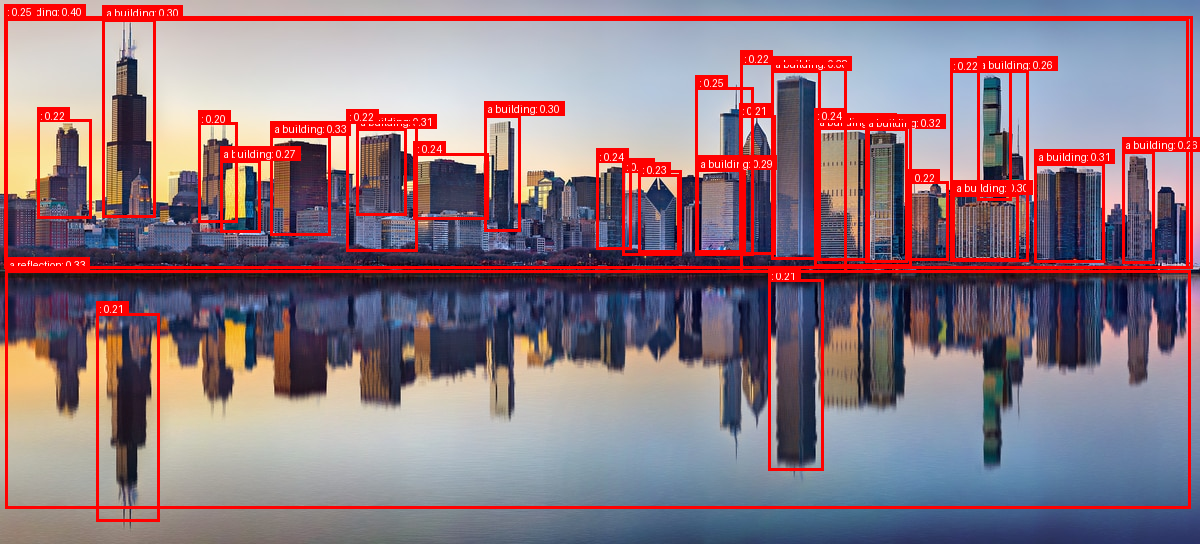

In [7]:
detection_client = DetectionClient(IMAGE_BASE_URL)

print(detection_client.health_check())
detection_results = detection_client.detect(TEST_IMAGE, ["a building", "a reflection of a building"], threshold=0.2)
draw_detections(TEST_IMAGE, detection_results)

### Image Segmentation

{'status': 'healthy', 'device': 'cuda', 'model': 'facebook/sam2.1-hiera-large'}


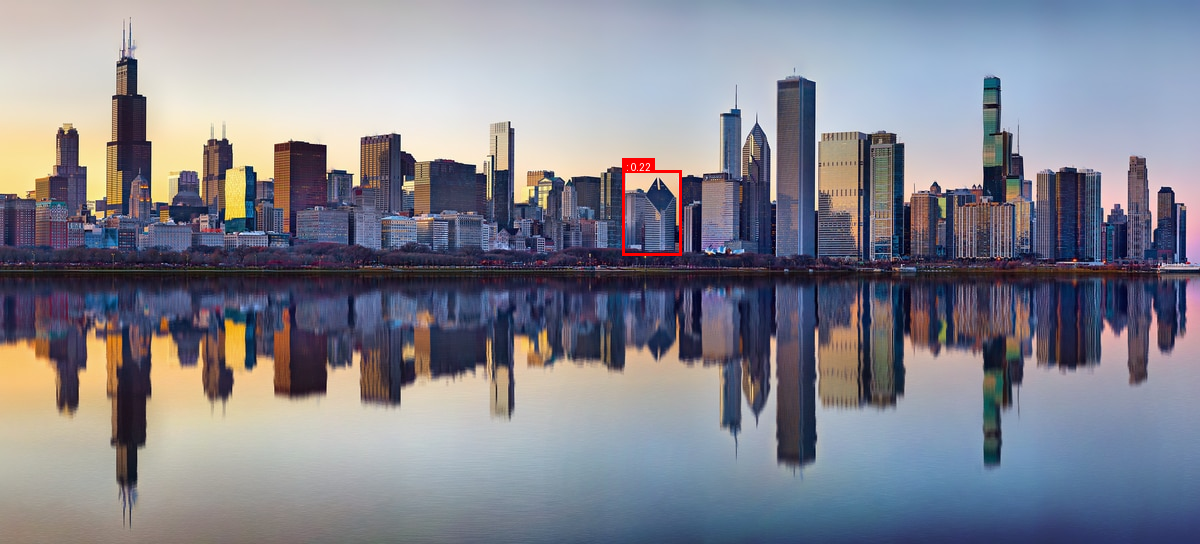

In [8]:
segmentation_client = SegmentationClient(IMAGE_BASE_URL)
print(segmentation_client.health_check())

target_idx = 13
tmp_result = deepcopy(detection_results)
tmp_result.detections[0].boxes = [tmp_result.detections[0].boxes[target_idx]]
tmp_result.detections[0].labels = [tmp_result.detections[0].labels[target_idx]]
tmp_result.detections[0].scores = [tmp_result.detections[0].scores[target_idx]]

bbox = tmp_result.detections[0].boxes[0]
center_point = [int((bbox[0]+bbox[2])//2), int((bbox[1]+bbox[3])//2)]

draw_detections(TEST_IMAGE, tmp_result)

#### Point

{'scores': [0.912671685218811], 'shape': [1, 1, 544, 1200]}


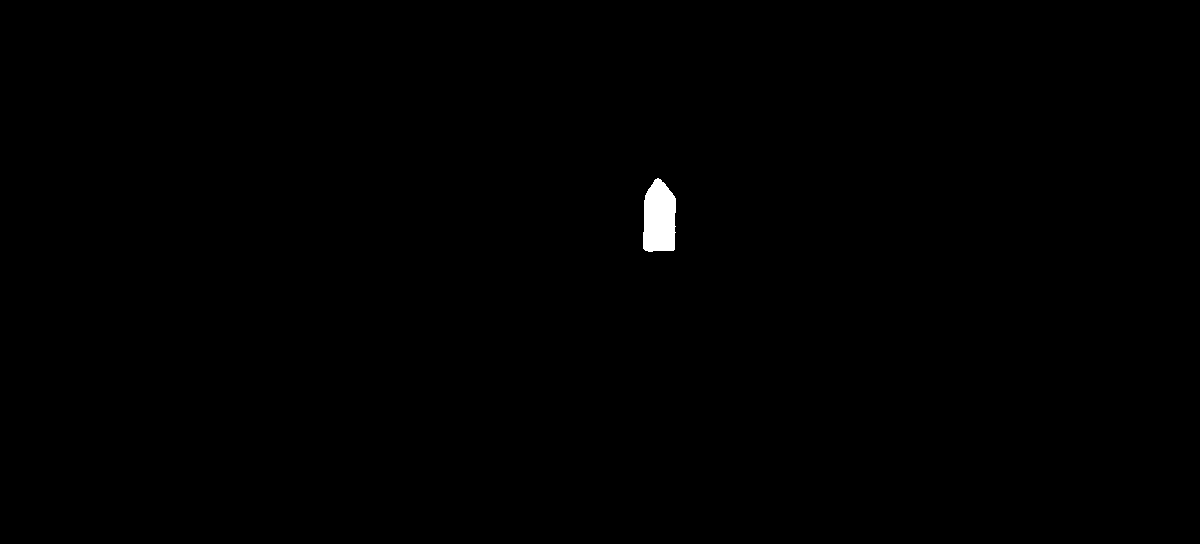

In [9]:
point_result = segmentation_client.segment_point(TEST_IMAGE, [center_point], [1])
print(point_result.get_metadata())
point_result.extract_masks()[0]

#### Box

{'scores': [0.9372897148132324], 'shape': [1, 1, 544, 1200]}


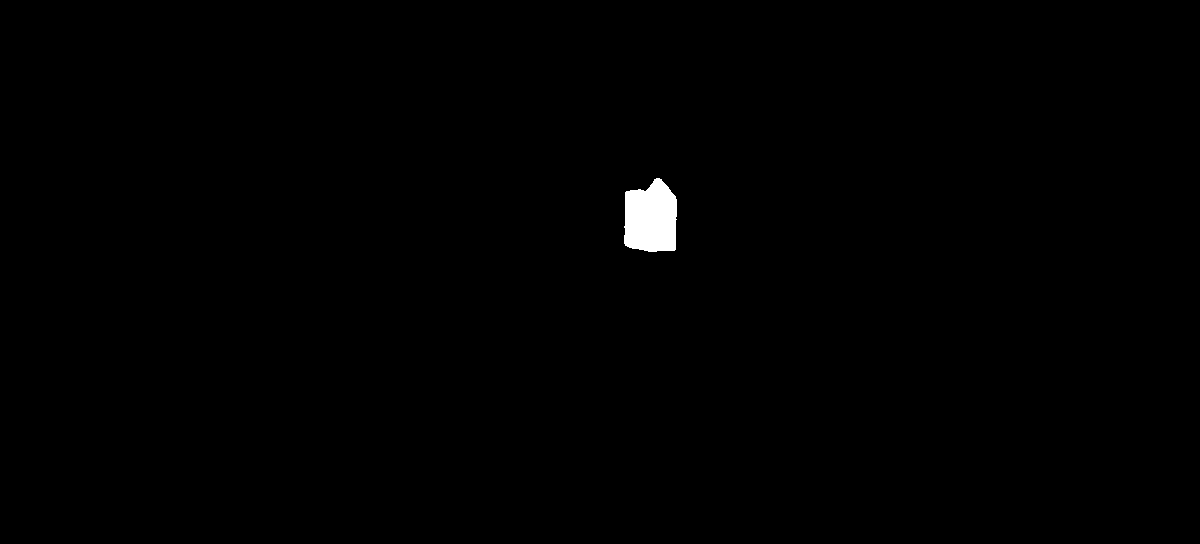

In [10]:
box_result = segmentation_client.segment_box(TEST_IMAGE, list(map(int, bbox)))
print(box_result.get_metadata())
box_result.extract_masks()[0]

#### Combined

{'scores': [0.8049447536468506], 'shape': [1, 1, 544, 1200]}


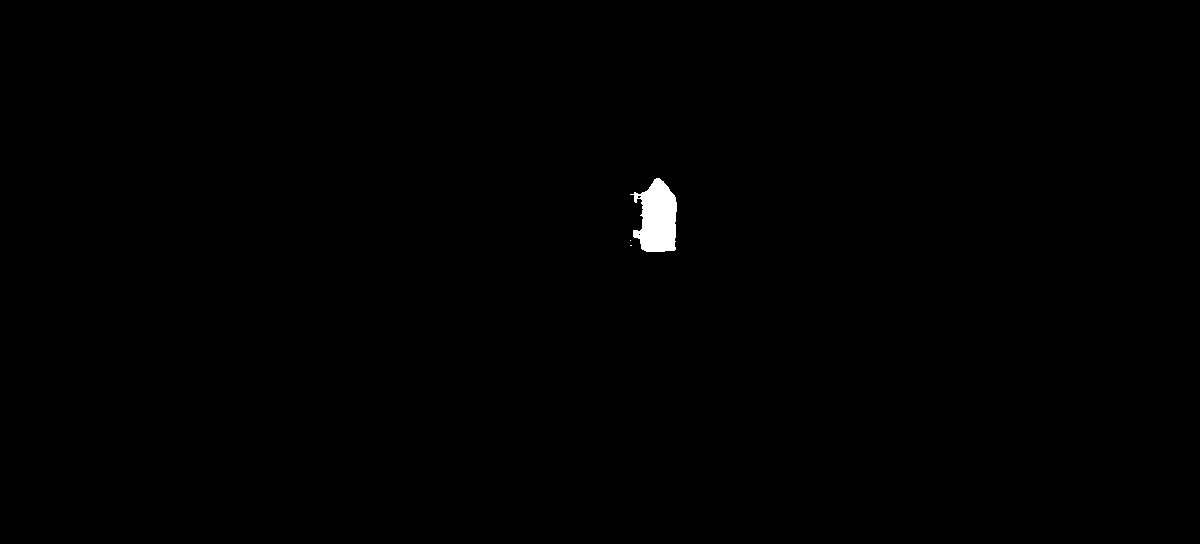

In [11]:
combined_result = segmentation_client.segment_combined(TEST_IMAGE, [[center_point[0] - 15, center_point[1]]], [0], list(map(int, bbox)))
print(combined_result.get_metadata())
combined_result.extract_masks()[0]